# Initialization

In [1]:
import os
import re
import numpy as np
import random
import time
import json

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

### set experiment dates

In [2]:
year = 2005 

### set run

In [3]:
run = 19

In [4]:
run_prefix = 'run_%s_xx' % run

### set directories

In [5]:
dir_root = os.path.join('..')
dir_data_runs = os.path.join(dir_root, 'data_runs')
dir_run = os.path.join(dir_data_runs, run_prefix)
dir_reports = os.path.join(dir_run, 'reports')
dir_plots = os.path.join(dir_run, 'interpretation', 't_search_plots')

In [6]:
if not os.path.exists(dir_plots):
    os.makedirs(dir_plots)

### set flags

In [7]:
flag_debug = False
flag_rerun_scan4T = False
flag_run_heldout = False
flag_serialize_findings = True
flag_de_serialize_findings = True
flag_print_tables = False

# Read data reports from files

In [8]:
def read_report(dir_name, file_name):
    file_path = os.path.join(dir_name, file_name)
    result = []
    with open(file_path, 'r') as f_r:
        for text_line in f_r:
            result = result + text_line.strip().split(' ')
    return result        

In [9]:
reports_list = []

if flag_rerun_scan4T:

    regExp = re.compile('[A-Z\d]+\_[A-Z\d]+\-' + str(year) + '\_[\d]+\.txt$')
    reports_of_year = [f for f in os.listdir(dir_reports) if re.search(regExp, f)]
    reports_of_year.sort()
    # for every reports of the year
    for report_name in reports_of_year:
        reports_list.append(read_report(dir_reports, report_name))

    print('Done on %s, number of documents: %s' % (year, len(reports_of_year)))

# Corpus construction

In [10]:
import gensim
import gensim.corpora as corpora

## Create Dictionary

In [11]:
id2word = corpora.Dictionary(reports_list)

## Create Corpus

Shuffle reporst

In [12]:
seed = 193748

Best randon seed is 99

In [13]:
random.Random(seed).shuffle(reports_list)

Split between training and test set

In [14]:
testing_size = len(reports_list) // 10
training_size = len(reports_list) - testing_size

In [15]:
print('Total %s reprorts' % len(reports_list))
print('Training %s reprorts' % training_size)
print('Testing %s reprorts' % testing_size)

Total 0 reprorts
Training 0 reprorts
Testing 0 reprorts


In [16]:
training_corpus = [id2word.doc2bow(text) for text in reports_list[:training_size]]
test_corpus = [id2word.doc2bow(text) for text in reports_list[:-testing_size]]

corpus = [id2word.doc2bow(text) for text in reports_list]

In [17]:
print('Number of unique tokens: %s' %len(id2word))

Number of unique tokens: 0


view the first document as BOW

In [18]:
if flag_debug:
    print(corpus[:1])

# Find optimal topic number

In [19]:
from gensim.models import CoherenceModel

In [20]:
def scan_T_gensim(dictionary, 
                  training_corpus, 
                  test_corpus, 
                  texts, 
                  limit, 
                  start=2, 
                  step=3, 
                  passes=10, 
                  random_state=100, 
                  run_perplexity=False):
    
    coherence_values = []
    train_p_values = []
    test_p_values = []
    model_list = []
    bound_values = []
    i = 0
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=training_corpus,
            id2word=dictionary,
            num_topics=num_topics, 
            random_state=random_state,
            passes=passes,
            alpha='auto',
            per_word_topics=True,
        )
        model_list.append(model)
        
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v_score = coherencemodel.get_coherence()
        coherence_values.append(c_v_score)
        if run_perplexity:         
            train_perplexity = np.exp2(-(model.log_perplexity(training_corpus)))
            train_p_values.append(train_perplexity)

            test_perplexity = np.exp2(-(model.log_perplexity(test_corpus)))
            test_p_values.append(test_perplexity)
        else:
            train_p_values.append(0)
            test_p_values.append(0)
        
        print('Done on indx: %s T: %s, c_v score: %s, Test perplexity: %s' % (i, num_topics, c_v_score, test_perplexity))
        
        i += 1
        
        
    return model_list, coherence_values, train_p_values, test_p_values


In [21]:
min_T = 5
max_T = 60
step_T = 1
passes_T = 100
random_state = 193748

In [22]:
model_list = []
coherence_values = []
train_perplexity_values = []
test_perplexity_values = []

Run with heldout test set

In [23]:
start = time.time()

if flag_rerun_scan4T and flag_run_heldout:
    model_list, coherence_values, train_perplexity_values, test_perplexity_values = scan_T_gensim(
        dictionary=id2word, 
        training_corpus=training_corpus, 
        test_corpus=test_corpus,
        texts=reports_list, 
        start=min_T, 
        limit=max_T, 
        step=step_T,
        passes=passes_T,
        random_state=random_state,
        run_perplexity = True,
    )
    
end = time.time() 

In [24]:
print('Execution time: %s minutes' % ((end - start)/60))

Execution time: 1.3550122578938803e-06 minutes


Run without heldout test set

In [25]:
if not flag_run_heldout and flag_rerun_scan4T:
    model_list, coherence_values, train_perplexity_values, test_perplexity_values = scan_T_gensim(
        dictionary=id2word, 
        training_corpus=corpus, 
        test_corpus=corpus,
        texts=reports_list, 
        start=min_T, 
        limit=max_T, 
        step=step_T,
        passes=passes_T,
        random_state=random_state,
        run_perplexity = False,
    )

In [26]:
import math
for i in range(len(coherence_values)):
    if math.isnan(coherence_values[i]):
        coherence_values[i] = 0

### serialize findings

In [27]:
scat_T_results = {
    'coherence_values': coherence_values, 
    'test_perplexity_values': test_perplexity_values,
}

if flag_serialize_findings and flag_rerun_scan4T:
    with open(os.path.join(dir_run, 'scan_T_values.json'), 'w') as f_w:
        f_w.write(json.dumps(scat_T_results))

### de-serialize findings

In [28]:
if flag_de_serialize_findings:
    coherence_values = []
    test_perplexity_values = []
    
    with open(os.path.join(dir_run, 'scan_T_values.json'), 'r') as f_w:
        data = json.load(f_w)
        coherence_values = data['coherence_values']
        test_perplexity_values = data['test_perplexity_values']

# Results

In [29]:
best_T_on_perplexity = None
best_T_on_coherence = None

In [30]:
topics_range = np.array(range(min_T, max_T + 1, step_T))
best_T_on_perplexity = topics_range[np.argmin(test_perplexity_values)]
best_T_on_coherence = topics_range[np.argmax(coherence_values)]

In [31]:
color_coherence = '#1f94f9'#hsl(208, 95%, 55%) # #1f94f9
color_perplexity = '#f9591f' #hsl(16, 95%, 55%) # #f9591f

## Compute PCR

In [60]:
def get_PCR(topics, perplexities):
    pcrs = [0]
    for i in range(1, len(topics)):
        pcr = ((perplexities[i] - perplexities[i - 1]) / (topics[i] - topics[i - 1]))
        pcrs.append(pcr)
        
    return pcrs

In [61]:
rpc_values = get_PCR(topics_range, test_perplexity_values)

## Compute normalized Perplexity

In [62]:
def get_normalized_perplexity(topics, perplexities):
    ps = []
    for t, p in zip(topics, perplexities):
        ps.append(p/t)
        
    return ps

In [63]:
normalised_perplexity_values = get_normalized_perplexity(topics_range, test_perplexity_values)

## Plot

In [64]:
def plot_topics_metric(ax, data, metric = '', label = '', color = 'red', best_is_max = True, with_interest_area = False, interest_area_center = 0, interest_area_size = 5):
    x = np.array(range(min_T, max_T + 1, step_T))
    y = np.array(data)

    ax.set_xlabel('Number of Topics, T')
    ax.set_ylabel(metric, color=color)
    ax.plot(x, y, color=color, label = label)   
    
    x_best = None
    y_best = None
    if with_interest_area:
        interest_area_min = interest_area_center - interest_area_size;
        interest_area_max = interest_area_center + interest_area_size;
        ax.axvspan(interest_area_min, interest_area_max, color='green', alpha=0.2) 

        x_best = interest_area_min + np.argmax(y[interest_area_min - min_T : (interest_area_max + 1) - min_T])
        y_best = y[interest_area_min - min_T : (interest_area_max + 1) - min_T].max()
    else: 
        if best_is_max:
            x_best = x[np.argmax(y)]
            y_best = y.max()
        else:
            x_best = x[np.argmin(y)]
            y_best = y.min()            

    text = 'Num of Topics=%s, score=%f' % (x_best, y_best)

    bbox_props = dict(boxstyle='square,pad=0.3', fc='w', ec='k', lw=0.72)
    arrowprops=dict(arrowstyle='->')
    kw = dict(xycoords='data',textcoords='axes fraction',
          arrowprops=arrowprops, bbox=bbox_props, ha='right', va='top')
    
    ax.annotate(text, xy=(x_best, y_best), xytext=(0.99,1.1), **kw)


### Plot Perplexity and PCR (Perplexity Change Rate)

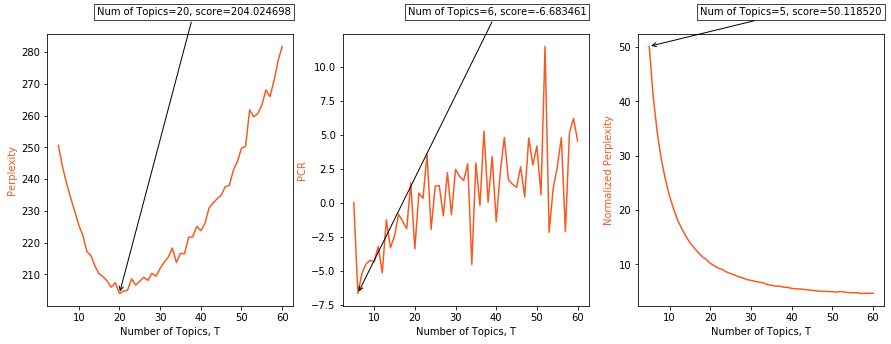

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

plot_topics_metric(
    axs[0], 
    test_perplexity_values,
    metric = 'Perplexity',
    label = 'Test Perplexity',
    color = color_perplexity,
    best_is_max = False
)
plot_topics_metric(
    axs[1], 
    rpc_values,
    metric = 'PCR',
    label = 'Perplexity Change Rate',
    color = color_perplexity,
    best_is_max = False
)
plot_topics_metric(
    axs[2], 
    normalised_perplexity_values,
    metric = 'Normalized Perplexity',
    label = 'Normalized Perplexity',
    color = color_perplexity,
    best_is_max = True
)

plt.show()
plt.close()

### Plot Coherence

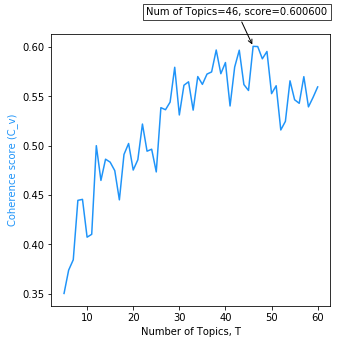

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))


plot_topics_metric(
    ax, 
    coherence_values,
    metric = 'Coherence score (C_v)',
    color = color_coherence,
)

plt.show()
plt.close()

### Plot Coherence with interest area around best perplexity

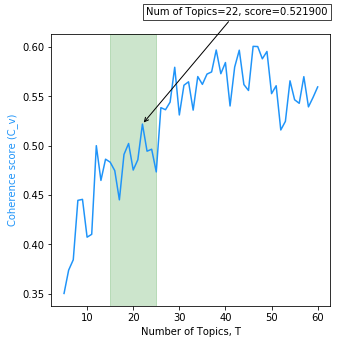

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

plot_topics_metric(
    ax, 
    coherence_values,
    metric = 'Coherence score (C_v)',
    color = color_coherence,
    with_interest_area = True,
    interest_area_center = best_T_on_perplexity
)

plt.show()
plt.close()

### Combined plot

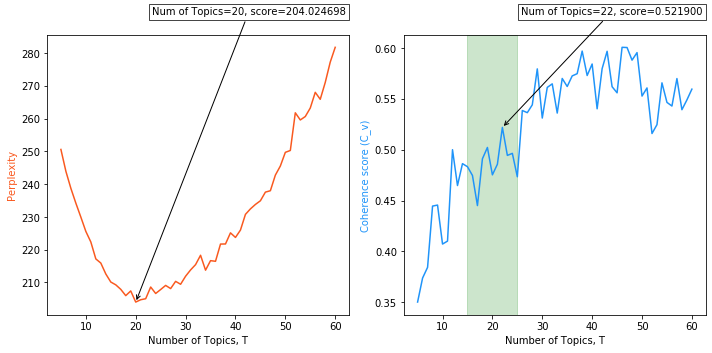

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

plot_topics_metric(
    axs[0], 
    test_perplexity_values,
    metric = 'Perplexity',
    color = color_perplexity,
    best_is_max = False
)
plot_topics_metric(
    axs[1], 
    coherence_values,
    metric = 'Coherence score (C_v)',
    color = color_coherence,
    with_interest_area = True,
    interest_area_center = best_T_on_perplexity
)

fig.tight_layout()
pp = PdfPages(os.path.join(dir_plots, 't_scan_combined_plot.pdf'))

plt.savefig(pp, format='pdf', bbox_inches='tight')
plt.show()

pp.close() 

## Tables

In [ ]:
all_columns = len(coherence_values)
columns = 10
rows = math.ceil(all_columns / columns)

In [ ]:
print('\\begin{table}[h!]')
print('\\centering')
print('\\caption{Scan for T}\\label{tabl_scan_for_t}')
print('\\begin{tabular}{l|%s}' % '|'.join(['c'] * columns))

for r in range(rows):
    start = r * columns
    end = (r + 1) * columns
    
    print('\\hline')
    print('\\textbf{T} & %s \\\\ ' % ' & '.join(['%s' % (x + 5) for x in range(start, end)]))
    print('\\hline')
    print('\\textbf{Coherence score}  & %s \\\\ ' % ' & '.join(['%.4f' % x for x in coherence_values[start:end]]))
    print('\\textbf{Perplexity score} & %s \\\\ ' % ' & '.join(['%.4f' % x for x in test_perplexity_values[start:end]]))
print('\\end{tabular}')
print('\\end{table}')

## Print top words for best model

In [ ]:
best_topics_number = best_T_on_coherence
best_model = model_list[best_topics_number - min_T]

In [ ]:
for i in range(best_topics_number):
    print([id2word.id2token[x[0]] for x in best_model.get_topic_terms(i, topn=5)])

In [ ]:
best_model.alpha

# END

In [ ]:
best_model.betha